In [ ]:
"""
Import libraries that require
"""

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split

plt.rcParams['font.sans-serif'] = ['Times New Roman']
sns.set_style("whitegrid")
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set(font_scale=1.2)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!pip install /content/gdrive/Shareddrives/520_Project/en_vectors_web_lg-2.1.0.tar.gz
import en_vectors_web_lg

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Processing ./gdrive/Shareddrives/520_Project/en_vectors_web_lg-2.1.0.tar.gz
DEPRECATION: Source distribution is being reinstalled despite an installed package having the same name and version as the installed package. pip 21.2 will remove support for this functionality. A possible replacement is use --force-reinstall. You can find discussion regarding this at https://github.com/pypa/pip/issues/8711.
  Created wheel for en-vectors-web-lg: filename=en_vectors_web_lg-2.1.0-py3-none-any.whl size=663461745 sha256=cdb874185bc0e66b69702a62b6fb8777d97b6464749f92450f1130c60467f7d8
  Stored in directory: /root/.cache/pip/wheels/74/83/a4/571203da0b401547ade1b9fd27a340a6ac7518814a03dd5ea6
Successfully built en-vectors-web-lg
  Attempting uninstall: en-vectors-web-lg
    Found existing installation: en-vectors-web-lg 2.1.0
    Uninstalling en-vectors-web-lg-2.1.0:
     

In [32]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
def sentiment_analysis(text):
  sid = SentimentIntensityAnalyzer()
  ss = sid.polarity_scores(text)
  return ss['compound']
print(sentiment_analysis('good great'))
print(sentiment_analysis('Love this dress! it\'s sooo pretty. i happened to find it in a store, and i\'m glad i did bc i never...'))
print(sentiment_analysis('Why do designers keep making crop tops??!! i can\'t imagine this would be flattering on anyone, espec...'))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
0.7906
0.8932
0.5013


In [ ]:
def get_glove_embedding(reviews, data_dir):
  # token_file = os.path.join(data_dir,'token_to_ix.pkl')
  # glove_file = os.path.join(data_dir,'train_glove.npy')
  # if os.path.exists(glove_file) and os.path.exists(token_file):
  #       print("Loading saved embedding")
  #       return pickle.load(open(token_file, "rb")), np.load(glove_file)
  vocab_limit = 5000
  all_reviews = {}
  for idx, s in enumerate(reviews):
    all_reviews[idx] = clean_text(s).split()

  from collections import defaultdict
  token_to_ix = defaultdict(int)
  token_to_ix['UNK'] = 1

  spacy_tool = en_vectors_web_lg.load()
  pretrained_emb = []
  pretrained_emb.append(spacy_tool('UNK').vector)
  
  for k, v in all_reviews.items():
      for word in v:
          if word not in token_to_ix:
              token_to_ix[word] = len(token_to_ix)
              pretrained_emb.append(spacy_tool(word).vector)

  token_to_ix = sorted(token_to_ix.items(), key = lambda kv: kv[1],reverse=True)
  token_to_ix = {kv[0]:i+2 for i,kv in enumerate(token_to_ix[:vocab_limit])}
  token_to_ix['UNK'] = 1
  for k in token_to_ix.keys():
      pretrained_emb.append(spacy_tool(k).vector)

  pretrained_emb = np.array(pretrained_emb)
  np.save(glove_file, pretrained_emb)
  pickle.dump(token_to_ix, open(token_file, "wb"))
  return token_to_ix, pretrained_emb
import re
def clean_text(w):
    return re.sub(
            r"([.,'!?\"()*#:;])",
            '',
            w.lower()
            ).replace('-', ' ').replace('/', ' ')
def embed_text(x, max_len, token2ix):
  ques_ix = np.zeros(max_len, np.int64)
  x = clean_text(x).split()
  for ix, word in enumerate(x):
    if word in token2ix:
      ques_ix[ix] = token2ix[word]
    else:
      ques_ix[ix] = 1
    if ix + 1 == max_len:
      break
  return ques_ix
data = pd.read_csv(os.path.join('/content/gdrive/Shareddrives/520_Project', "Womens_Clothing_E-Commerce_Reviews.csv"))
data['Review Text'] = data['Review Text'].fillna(' ')
token2ix, pretrained_emb = (data['Review Text'],'/content/gdrive/Shareddrives/520_Project')
lengths = [len(x.split()) for x in data['Review Text']]
max_len = int(np.percentile(lengths,90))
# new embedding array
data['embedded'] = data['Review Text'].apply(lambda x : embed_text(x,max_len,token2ix))

# Load Dataset

In [ ]:
data = pd.read_csv(os.path.join('/content/gdrive/Shareddrives/520_Project', "Womens_Clothing_E-Commerce_Reviews.csv"))
data.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


Choose "Review text" as features, and "Recommended IND" as labels. Split the data into training(80%), validation(10%) and testing sets(10%).

In [ ]:
# Split the data into training, validation and testing sets

# Output: X_train, X_dev, X_test; y_train, y_dev, y_test.
X_train, X_dev, y_train, y_dev = train_test_split(np.array(data['Review Text'].fillna(' ')), np.array(data['Recommended IND']), test_size=0.2, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_dev, y_dev, test_size=0.5, random_state=42)

print("Number of data points in training, validation and testing set:", X_train.shape[0], X_dev.shape[0], X_test.shape[0])

Number of data points in training, validation and testing set: 18788 2349 2349


Visualize input data.

In [ ]:
X_train[0]

"I passed over this dress online thinking i'd never wear it. but, then i found myself inside an retailer store and decided to try it on. i am excited to say that i love this dress. it is soft and lovely. the cowl is large and the whole dress has a really great drape. my favorite thing is that the buttons along the back are functional. opening up the back turns this dress into a long cardigan that is to die for."

# Data Pre-processing


## Remove stop-words

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

def preprocess_text(x):
    if type(x) != str: return(x)
    stop = stopwords.words("english") + list(string.punctuation)
    x = x.lower()
    lemmatizer = WordNetLemmatizer()
    porter_stemmer = PorterStemmer()
    x = " ".join([lemmatizer.lemmatize(word) for word in x.split() if word not in stop])
    x = " ".join([porter_stemmer.stem(word) for word in x.split() if word not in stop])
    return x
    
data['Processed Review Text'] = data['Review Text'].apply(lambda x : preprocess_text(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Output: X_train_pre, X_dev_pre, X_test_pre; y_train_pre, y_dev_pre, y_test_pre.
X_train_pre, X_dev_pre, y_train_pre, y_dev_pre = train_test_split(np.array(data['Processed Review Text'].fillna(' ')), np.array(data['Recommended IND']), test_size=0.2, random_state=42)
X_dev_pre, X_test_pre, y_dev_pre, y_test_pre = train_test_split(X_dev_pre, y_dev_pre, test_size=0.5, random_state=42)

Visualize after removing stop-words.

In [ ]:
X_train_pre[0]

"pass dress onlin think i'd never wear it. but, found insid retail store decid tri on. excit say love dress. soft lovely. cowl larg whole dress realli great drape. favorit thing button along back functional. open back turn dress long cardigan die for."

 ## TF-IDF embedding

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer() # ngram_range=(2,4), tokenizer=tokenize,
                        # min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
                        # smooth_idf=1, sublinear_tf=1

# term_doc = vec.fit_transform(data['Review Text'].fillna(' '))

In [ ]:
# Input: X_train, X_dev, X_test; y_train, y_dev, y_test.
# Output: train_term_doc, dev_term_doc, test_term_doc; y_train, y_dev, y_test.
train_term_doc = vec.fit_transform(X_train).toarray()
dev_term_doc = vec.transform(X_dev).toarray()
test_term_doc = vec.transform(X_test).toarray()

print("Shape after TF-IDF embedding:", train_term_doc.shape, dev_term_doc.shape, test_term_doc.shape)

Shape after TF-IDF embedding: (18788, 12877) (2349, 12877) (2349, 12877)


Visualize after TF-IDF embedding.

In [ ]:
train_term_doc[0].shape

(12877,)

In [ ]:
# Input: X_train_pre, X_dev_pre, X_test_pre; y_train_pre, y_dev_pre, y_test_pre.
# Output: train_term_doc_pre, dev_term_doc_pre, test_term_doc_pre; y_train_pre, y_dev_pre, y_test_pre.
train_term_doc_pre = vec.fit_transform(X_train_pre).toarray()
dev_term_doc_pre = vec.transform(X_dev_pre).toarray()
test_term_doc_pre = vec.transform(X_test_pre).toarray()

print("Shape after removing stop-words and TF-IDF embedding:", train_term_doc_pre.shape, dev_term_doc_pre.shape, test_term_doc_pre.shape)

Shape after removing stop-words and TF-IDF embedding: (18788, 12005) (2349, 12005) (2349, 12005)


Visualize after removing stop-words and TF-IDF embedding.

In [ ]:
train_term_doc_pre[0].shape

(12005,)

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer
# cnt_vec = CountVectorizer(ngram_range=(1, 2))
# train_cnt_vec = cnt_vec.fit_transform(X_train).toarray() # OOM
# dev_cnt_vec = cnt_vec.transform(X_dev).toarray()

## Create one-hot vectors for categorical features

Categorical features includes "Division Name", "Department Name", and "Class Name".

In [ ]:
meta_cols = ['Division Name', 'Department Name', 'Class Name']

def col2ix(x,col_cnt):
  if x in col_cnt:
    return col_cnt[x]
  return len(col_cnt.keys())

dummy_names = []
for c in meta_cols:
  col_cnt = {value:idx for idx, value in enumerate(list(set(data[c])))}
  data[c + '_'] = data[c].apply(lambda x: col2ix(x, col_cnt))
  dummies = pd.get_dummies(data[c + '_'], prefix=c.split()[0])
  names = list(dummies.columns)
  data = pd.concat((data, dummies), axis=1)
  dummy_names += names

In [ ]:
data.head(3)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Processed Review Text,Division Name_,Division_0,Division_1,Division_2,Division_3,Department Name_,Department_0,Department_1,Department_2,Department_3,Department_4,Department_5,Department_6,Class Name_,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11,Class_12,Class_13,Class_14,Class_15,Class_16,Class_17,Class_18,Class_19,Class_20
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,absolut wonder silki sexi comfort,3,0,0,0,1,0,1,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,"love dress! sooo pretty. happen find store, i'...",2,0,0,1,0,5,0,0,0,0,0,1,0,9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,high hope dress realli want work me. initi ord...,2,0,0,1,0,5,0,0,0,0,0,1,0,9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# data['Processed Review Text_'] = data['Processed Review Text'].fillna(' ')
other_features = ['Clothing ID', 'Age', 'Positive Feedback Count']
all_cols = dummy_names + other_features
print("Number of dummy names:", len(dummy_names))
print("Number of real-num features:", len(other_features))
X_train_total, X_dev_total, y_train_total, y_dev_total = train_test_split(np.array(data[all_cols]), np.array(data['Recommended IND']), test_size=0.2, random_state=42)
X_dev_total, X_test_total, y_dev_total, y_test_total = train_test_split(X_dev_total, y_dev_total, test_size=0.5, random_state=42)

Number of dummy names: 32
Number of real-num features: 3


In [ ]:
# with meta data

# without stop-words removed
train_term_doc_total = np.concatenate((X_train_total, train_term_doc), axis=1)
dev_term_doc_total = np.concatenate((X_dev_total, dev_term_doc), axis=1)
test_term_doc_total = np.concatenate((X_test_total, test_term_doc), axis=1)
print("Shape after TF-IDF embedding and concatenate all features:", train_term_doc_total.shape, dev_term_doc_total.shape, test_term_doc_total.shape)

# with stop-words removed
train_term_doc_pre_total = np.concatenate((X_train_total, train_term_doc_pre), axis=1)
dev_term_doc_pre_total = np.concatenate((X_dev_total, dev_term_doc_pre), axis=1)
test_term_doc_pre_total = np.concatenate((X_test_total, test_term_doc_pre), axis=1)
print("Shape after removing stop-words, TF-IDF embedding and and concatenate all features:", train_term_doc_pre_total.shape, dev_term_doc_pre_total.shape, test_term_doc_pre_total.shape)

Shape after TF-IDF embedding and concatenate all features: (18788, 12912) (2349, 12912) (2349, 12912)
Shape after removing stop-words, TF-IDF embedding and and concatenate all features: (18788, 12040) (2349, 12040) (2349, 12040)


In [ ]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
scaler = StandardScaler()

train_term_doc_total = scaler.fit_transform(train_term_doc_total)
dev_term_doc_total = scaler.transform(dev_term_doc_total)
test_term_doc_total = scaler.transform(test_term_doc_total)

train_term_doc_pre_total = scaler.fit_transform(train_term_doc_pre_total)
dev_term_doc_pre_total = scaler.transform(dev_term_doc_pre_total)
test_term_doc_pre_total = scaler.transform(test_term_doc_pre_total)

**Summary**

TF-IDF: train_term_doc, y_train.

TF-IDF + stop-words: train_term_doc_pre, y_train_pre.

TF-IDF + one-hot for categorical features: train_term_doc_total, y_train.


TF-IDF + stop-words + one-hot for categorical features: train_term_doc_pre_total, y_train_pre.

# Method

In [34]:
from sklearn.metrics import roc_curve, auc, roc_auc_score


def plot_ROC(y_test, y_score, models_name):
  print(y_test.shape, y_score.shape)
  n = y_score.shape[1]
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n):
    fpr[i], tpr[i], _ = roc_curve(np.reshape(y_test, (-1, 1)), y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure()
  lw = 2
  for i in range(n):
    plt.plot(
        fpr[i],
        tpr[i],
        # color="darkorange",
        lw=lw,
        label="ROC curve of {0} (area = {1:0.2f})" .format(models_name[i], roc_auc[i]),
    )
  plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver operating characteristic example")
  plt.legend(loc="lower right")
  plt.show()

def plot_ROC_test(y_test, y_score):
  # print(y_test.shape, y_score.shape)
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  fpr, tpr, _ = roc_curve(y_test, y_score)
  roc_auc = auc(fpr, tpr)

  plt.figure()
  lw = 2
  plt.plot(
      fpr,
      tpr,
      color="darkorange",
      lw=lw,
      label="ROC curve (area = %0.2f)" % roc_auc,
  )
  plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver operating characteristic example")
  plt.legend(loc="lower right")
  plt.show()

In [35]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,VotingClassifier,GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from xgboost import XGBClassifier


# models = {'Decision Tree': DecisionTreeClassifier()}

In [36]:
def evaluate_p_r_f1_acc(y_pred, y_true):
    precision = precision_score(y_pred, y_true)
    recall = recall_score(y_pred, y_true)
    fscore = f1_score(y_pred, y_true)
    acc = accuracy_score(y_pred, y_true)
    return precision, recall, fscore, acc

In [37]:
def evaluate_baseline(train_vec, dev_vec, y_train, y_dev, model):
  clf = model
  start = time.time()
  clf.fit(train_vec, y_train)
  end = time.time()
  y_pred = clf.predict(dev_vec)
  p, r, fscore, acc = evaluate_p_r_f1_acc(y_pred, y_dev)
  print('Precision: ', p, '\tRecall: ', r, '\tF-score: ', fscore, '\tacc: ', acc, "\tTraining time: ", end - start)
  plot_ROC_test(y_pred, y_dev)
  # print(roc_auc_score(y_pred, y_dev))
  print("Total number of recommended: ", sum(y_pred))

  # plot_ROC(y_pred, y_dev)
  return np.reshape(y_pred, (-1, 1))

In [38]:
def preprocess_experiment(model):
  # print("TF-IDF:")
  # evaluate_baseline(train_term_doc, dev_term_doc, y_train, y_dev, model)
  # print("TF-IDF + stop-words:")
  # evaluate_baseline(train_term_doc_pre, dev_term_doc_pre, y_train_pre, y_dev_pre, model)
  # print("TF-IDF + one-hot for categorical features:")
  # evaluate_baseline(train_term_doc_total, dev_term_doc_total, y_train, y_dev, model)
  # print("TF-IDF + stop-words + one-hot for categorical features:")
  # evaluate_baseline(train_term_doc_pre_total, dev_term_doc_pre_total, y_train_pre, y_dev_pre, model)
  print("Features without Review Text:")
  return evaluate_baseline(X_train_total, X_dev_total, y_train_total, y_dev_total, model)

Current Algorithm: Logistic Regression
Features without Review Text:
Precision:  0.9994845360824742 	Recall:  0.8261610566680869 	F-score:  0.9045952880802426 	acc:  0.8258833546189868 	Training time:  0.47557497024536133


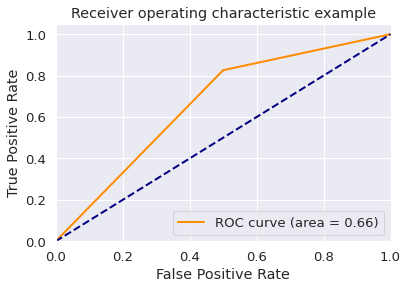

Total number of recommended:  2347
Current Algorithm: Decision Tree
Features without Review Text:
Precision:  0.8082474226804124 	Recall:  0.83448642895157 	F-score:  0.8211573710395391 	acc:  0.7092379736057897 	Training time:  0.11396121978759766


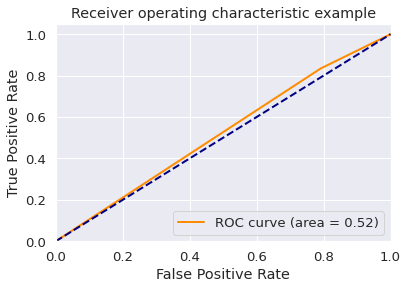

Total number of recommended:  1879
Current Algorithm: Random Forest
Features without Review Text:
Precision:  0.9309278350515464 	Recall:  0.8292011019283747 	F-score:  0.8771248178727539 	acc:  0.7845891868880375 	Training time:  2.0116097927093506


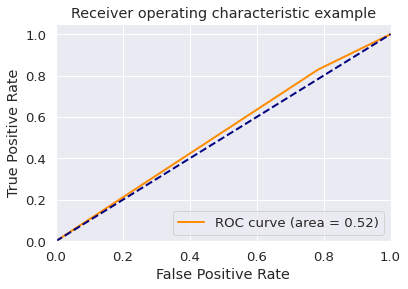

Total number of recommended:  2178
Current Algorithm: XGBoost
Features without Review Text:
Precision:  1.0 	Recall:  0.8258833546189868 	F-score:  0.9046397761716017 	acc:  0.8258833546189868 	Training time:  1.8326101303100586


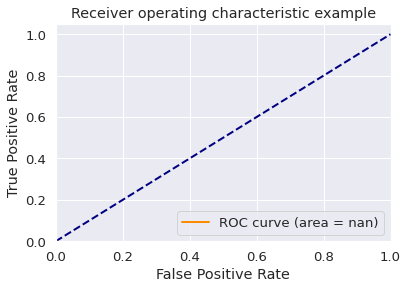

Total number of recommended:  2349
Current Algorithm: Extra Trees
Features without Review Text:
Precision:  0.8886597938144329 	Recall:  0.8268585131894485 	F-score:  0.8566459627329194 	acc:  0.7543635589612601 	Training time:  2.0937204360961914


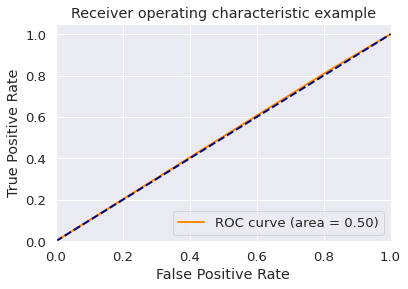

Total number of recommended:  2085
Current Algorithm: SVM
Features without Review Text:
Precision:  1.0 	Recall:  0.8258833546189868 	F-score:  0.9046397761716017 	acc:  0.8258833546189868 	Training time:  10.291636943817139


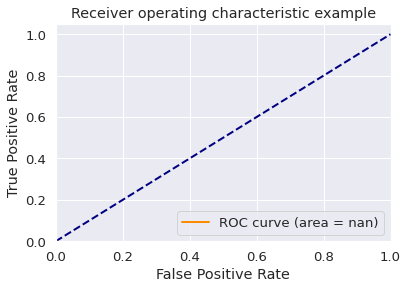

Total number of recommended:  2349
Current Algorithm: AdaBoost
Features without Review Text:
Precision:  1.0 	Recall:  0.8262350936967632 	F-score:  0.9048507462686567 	acc:  0.8263090676883781 	Training time:  1.7651503086090088


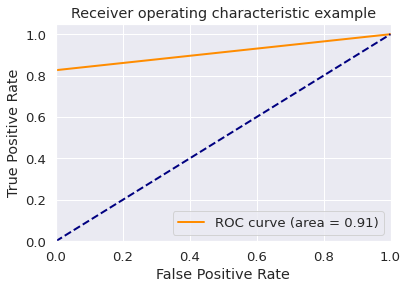

Total number of recommended:  2348
(2349,) (2349, 7)


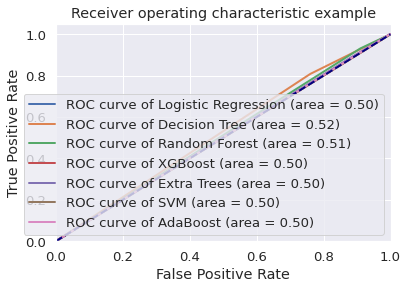

In [39]:
models = {'Logistic Regression': LogisticRegression(), 
          'Decision Tree': DecisionTreeClassifier(), 
          'Random Forest': RandomForestClassifier(),
          # 'Soft-Voting (Ensemble)': VotingClassifier(),
          'XGBoost': XGBClassifier(),
          'Extra Trees': ExtraTreesClassifier(),
          'SVM': SVC(), 
          'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=0)
          }

models_name = list(models)
y_predict_collection = np.empty((y_dev.shape[0], 1), int)

for model in models:
  print("Current Algorithm:", model)
  y_hat = preprocess_experiment(models[model])
  y_predict_collection = np.append(y_predict_collection, y_hat, axis = 1)

y_predict_collection = y_predict_collection[:, 1:]
plot_ROC(y_dev, y_predict_collection, models_name)

In [ ]:
print(train_term_doc.shape, dev_term_doc.shape, y_train.shape, y_dev.shape, X_train_total.shape, X_dev_total.shape, y_train_total.shape, y_dev_total.shape)
print("Total number of recommended: ", sum(y_dev))

In [ ]:
# Precision:  0.9732258903041331 	Recall:  0.8982725527831094 	F-score:  0.9342482844666251 	acc:  0.8878246062154108

# Non-context features

In [ ]:
# haven't done

def extract_non_context_features(review):
    min_valence=[] # positive/negative
    mean_valence=[]
    max_valence=[]
    # todo sentiment
    cnt=0
    valence=[]
    review = re.sub(
            r"([.,'!?\"\'(<>)*#:;])",
            '',
            review.lower()
        ).replace('-', ' ').replace('/', ' ').split() 

    blob = TextBlob(text)  
    token = blob.words
    for w in token:
      print(w)
    for sentence in blob.sentences:
    print(sentence + '------>'+ str(sentence.sentiment.polarity))

    for w in review:
        if w in valence_dict:
            valence.append(valence_dict[w])
    if valence:
        min_valence.append(min(valence))
        mean_valence.append(np.mean(valence))
        max_valence.append(max(valence))
    
    # pos tag features
    pos_features(review)


    feature_list=[
        # sentiment_score,
        np.mean(min_valence),# 
        np.mean(mean_valence),# 
        np.mean(max_valence),# 
        len(review) # total_len
        # pos tag frequencies
        ]
    return feature_list

def pos_features(text):
    stop = stopwords.words("english") + list(string.punctuation)
    word_list=[i for i in word_tokenize(str(text).lower()) if i not in stop]
    tag_list_stop = nltk.pos_tag(word_list)
    # print(tag_list_stop[:5]) # [("'okay", 'POS'), ("'how", 'PRP'), ("'bout", 'IN'),
    word_tag_fq = nltk.FreqDist(tag_list_stop) # (10) word frequency rate
    tag_list = word_tag_fq.most_common() # [(("'you", 'POS'), 53), (("'and", 'CD'), 36), (("'know", 'POS'), 32),
    tags=[i[0][1] for i in tag_list]
    tags_dict=dict(Counter(tags))
    # print(tags_dict) # {'POS': 10, 'CD': 9, 'IN': 8, ... 
    # (1) number of pronouns
    num_pronoun=0
    for t in ['NNP','NNPS','PRP','WP']:
        if t in tags_dict:
            num_pronoun += tags_dict[t]
    print('num of pronouns',num_pronoun)
    # (2) pronoun-noun ratio
    num_noun=0
    for t in ['NN','NNS']:
        if t in tags_dict:
            num_noun += tags_dict[t]
    pron_noun_ratio = num_pronoun/num_noun
    print('pronoun-noun ratio',num_pronoun,'/',num_noun,'=',pron_noun_ratio)
    # (3) number of adverbs
    num_adv=0
    for t in ['RB','RBR','RBS']:
        if t in tags_dict:
            num_adv += tags_dict[t]
    print('num of adverb',num_adv)
    # (4) number of nouns
    print('num of nouns',num_noun)
    # (5) number of verbs
    num_verb=0
    for t in ['VB','VBD','VBG','VBN','VBP','VBZ']:
        if t in tags_dict:
            num_verb += tags_dict[t]
    print('num of verb',num_verb)
    # (6) pro-noun frequency rate,(7) noun frequency rate, (8) verb frequency rate, (9) adverb frequency rate
    pron_freq_rate = num_pronoun/len(word_list)
    noun_freq_rate = num_noun/len(word_list)
    verb_freq_rate = num_verb/len(word_list)
    adv_freq_rate = num_adv/len(word_list)

    # (10) word frequency rate
    word_dict = dict(Counter(word_list))
    cnt=0
    for i in word_dict:
        if word_dict[i]>=10:
            cnt+=word_dict[i]
            # print('wo stop',i,word_dict[i])
    print('word freq rate:',cnt,'/',len(word_list))
    word_freq_rate=cnt/len(word_list)
    
    return np.array([
        num_pronoun,pron_noun_ratio,num_adv,num_noun,num_verb,
        pron_freq_rate,noun_freq_rate,verb_freq_rate,adv_freq_rate,
        word_freq_rate
    ])

In [ ]:
# all_feature = []
# for 